In [1]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
import pubchempy as pcp
os.chdir('../')
from util.util import *
os.chdir('notebooks')


import IPython.display as Disp

# Feature Selection (PubChem Organic Molecules Dataset)

In [35]:
pl_desc = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
pl_desc = pl_desc[pl_desc.columns[1:]]

org_desc = pd.read_pickle('../data/pubchem/descriptors/org_chem_pubc.pkl')
org_desc = org_desc[~org_desc.isin([np.nan, np.inf, -np.inf]).any(1)]
org_desc = org_desc.reset_index(drop=True)

In [36]:
shared_cols = set(pl_desc.columns).intersection(set(org_desc.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

In [37]:
pl_data = pl_desc[shared_cols]
org_data = org_desc[shared_cols]
ones = np.ones((pl_data.shape[0],1))
zeros = np.zeros((org_data.shape[0],1))
pl_data = np.hstack((pl_data, ones))
org_data = np.hstack((org_data, zeros))

In [65]:
def lasso_selection(pl_data, org_data, org_smiles, best_orgs, scaling_factor=1)
    rand_idxs = np.random.choice(np.arange(len(pl_data)), size=len(pl_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]

    pl_train = pl_data[train_idxs,:]
    pl_test = pl_data[test_idxs,:]

    rand_idxs = np.random.choice(np.arange(len(org_data)), size=len(org_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    org_train = org_data[train_idxs,:]
    org_test = org_data[test_idxs,:]
    org_smiles_test = org_smiles[test_idxs]

    train_data = np.concatenate([pl_train, org_train], axis=0)
    test_data = np.concatenate([pl_test, org_test], axis=0)
    np.random.shuffle(train_data)

    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
    sel_.fit(X_train, y_train)
    
    X_train_sel = X_train[:,sel_.get_support()]
    X_test_sel = X_test[:,sel_.get_support()]
    
    pca = PCA(n_components=2)
    train_ics = pca.fit_transform(X_train_sel)
    test_ics = pca.transform(X_test_sel)
    
    pl_ics = train_ics[np.where(y_train == 1)]
    org_ics = train_ics[np.where(y_train == 0)]
    test_pl_ics = test_ics[np.where(y_test == 1)]
    test_org_ics = test_ics[np.where(y_test == 0)]
    
    pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
    pc1_min = math.floor(pc1_all.min())
    pc1_max = math.ceil(pc1_all.max())
    pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
    pc2_min = math.floor(pc2_all.min())
    pc2_max = math.ceil(pc2_all.max())
    
    kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
    pl_test_kdes = []
    pl_train_kdes = []
    org_kdes = []
    for pl_sample in test_pl_ics:
        pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for pl_sample in pl_ics:
        pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for org_sample in test_org_ics:
        org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))
    
    org_hits_kde_best, org_hits_sm_best = zip(*reversed(sorted(zip(org_kdes, org_smiles_test))))
    for i, smile in enumerate(org_hits_sm_best):
        best_orgs[smile][0] += 1
        best_orgs[smile][1] += org_hits_kde_best[i]
    return best_orgs

In [66]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(X_train, y_train)

/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [67]:
sel_cols = np.array(list(shared_cols))[sel_.get_support()]

In [68]:
len(sel_cols)

26

## Rerun Likelihood With Only LASSO Selected Columns

In [69]:
X_train_sel = X_train[:,sel_.get_support()]
X_test_sel = X_test[:,sel_.get_support()]

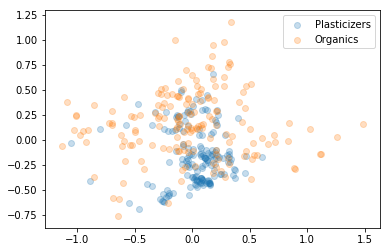

In [70]:
pca = PCA(n_components=2)
train_ics = pca.fit_transform(X_train_sel)
test_ics = pca.transform(X_test_sel)
pl_ics = train_ics[np.where(y_train == 1)]
org_ics = train_ics[np.where(y_train == 0)]
test_pl_ics = test_ics[np.where(y_test == 1)]
test_org_ics = test_ics[np.where(y_test == 0)]

plt.scatter(pl_ics[:,0], pl_ics[:,1], label="Plasticizers", alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='Organics', alpha=0.25)
plt.legend(loc='best')
plt.show()

In [71]:
kde, xs, ys = calc_2D_kde(pl_ics, [-1.0,1.5], [-1.5,2.0])

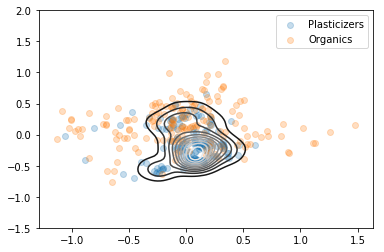

In [72]:
plt.contour(xs, ys, kde, levels=10, cmap='gray')
plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='Organics', alpha=0.25)
plt.legend(loc='best')
plt.show()

In [75]:
pl_test_kdes = []
pl_train_kdes = []
org_kdes = []
for pl_sample in test_pl_ics:
    pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for pl_sample in pl_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for org_sample in org_ics:
    org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))

In [76]:
boundary = 0.2
pl_train_acc = eval_acc(pl_train_kdes, boundary)
pl_test_acc = eval_acc(pl_test_kdes, boundary)
org_hit_percent = eval_acc(org_kdes, boundary)
print("Train Accuracy - {}%".format(round(pl_train_acc*100, 2)))
print("Test Accuracy - {}%".format(round(pl_test_acc*100, 2)))
print("Org Hit Percent - {}% ({} / {} samples)".format(round(org_hit_percent*100, 2), int(org_hit_percent*len(org_kdes)), len(org_kdes)))

Train Accuracy - 94.64%
Test Accuracy - 92.86%
Org Hit Percent - 51.79% (87 / 168 samples)
